Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

In [1]:
# import important stuff
import numpy as np
import pandas as pd
import datetime
from collections import Counter

In [2]:
# import visulization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [3]:
# import stats modules
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency

In [4]:
# import sklearn modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

In [5]:
# import take home users data 
df_users = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'], encoding = "ISO-8859-1")
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [7]:
df_users['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [8]:
# import user engagement data 
df_user_engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'], encoding = "ISO-8859-1")
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [13]:
# how many users signed up?
n_users = df_users['object_id'].nunique()

# how many users have done any engagement?
n_users_engaged = df_user_engagement['user_id'].nunique()

# percentage of active users among signed up
print('The percentage of users actually engaged with the application is: ', n_users_engaged/n_users*100)

The percentage of users actually engaged with the application is:  73.52499999999999


In [9]:
# what is visited?
df_user_engagement['visited'].value_counts()

1    207917
Name: visited, dtype: int64

The feature "visited' in the user engagement data has only one value. It does not contain much information thus could be dropped. Now we try to complete first part of the problem: defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period.

In [10]:
# drop the visited column
df_user_engagement.drop(['visited'], axis=1, inplace=True)

In [11]:
# mark the users whether they are "adopted" or not
user_ls = sorted(list(df_user_engagement['user_id'].unique()))
seven_days = datetime.timedelta(7)
user_adopt = []

for i in user_ls:

    stamp = 0
    i_user = df_user_engagement[df_user_engagement['user_id']==i].sort_values('time_stamp')
    
    for row in i_user.itertuples():
        if stamp == 1:
            continue
        login_time = i_user.at[(row[0], 'time_stamp')]
        if len(i_user[(i_user['time_stamp'] > login_time) & (i_user['time_stamp'] < (login_time + seven_days))]) >= 3:
            stamp = 1
    
    user_adopt.append(stamp)

In [14]:
# find the percentage of active users that are adopted users
df_user_adopt = pd.DataFrame(user_ls, user_adopt).reset_index()
df_user_adopt.columns = ['Adopt', 'user_id']
adopt_percent = df_user_adopt.Adopt.value_counts(normalize=True)[1]
adopt_percent_total = df_user_adopt.Adopt.value_counts()[1]/n_users

print("The percentage of adopted user among active user is", adopt_percent)
print("The percentage of adopted user among signed up user is", adopt_percent_total)

The percentage of adopted user among active user is 0.14700215346254109
The percentage of adopted user among signed up user is 0.10808333333333334


In [15]:
# merge two data frames 
df_merge = df_users.merge(df_user_adopt, how='left', left_on='object_id', right_on='user_id' )
df_merge.fillna(value=0, inplace=True)

In [16]:
# drop some arbiturary features that are irrelevant with the user itself
df_classify = df_merge.drop(['object_id', 'name', 'user_id', 'creation_time', 'last_session_creation_time'], axis=1)

Create a feature that indicates whether the sign-up email is a popular email host site (such as 'gmail') or some random or personal host.

In [17]:
df_classify['email_source'] = df_classify['email'].apply(lambda x: x.split('@')[1])
email_list = df_classify['email_source'].value_counts().head(6).index.tolist()
email_type_ls = []

for email in df_classify['email_source']:
    if email in email_list:
        email_type_ls.append(1)
    else:
        email_type_ls.append(0)
        
df_classify['email_type'] = email_type_ls
df_classify.drop(['email', 'email_source'],axis=1, inplace=True)

In [18]:
# catagorical features get dummies
catagoric = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'email_type' ]
others = df_classify.columns.difference(catagoric)
df_dummies = pd.get_dummies(data=df_classify, columns=catagoric, drop_first=True)

In [19]:
df_dummies['Adopt'] = df_dummies['Adopt'].astype('category')
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
Adopt                                 12000 non-null category
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
opted_in_to_mailing_list_1            12000 non-null uint8
enabled_for_marketing_drip_1          12000 non-null uint8
email_type_1                          12000 non-null uint8
dtypes: category(1), float64(1), int64(1), uint8(7)
memory usage: 375.1 KB


In [20]:
# feature selection
# do chi-squared test on catagoric features
p_vals_cate = pd.DataFrame(columns=['Attribute', 'P_value'])
categoric = df_dummies.columns.difference(others)
p_large = []


for col in categoric:
    df_dummies[col] = df_dummies[col].astype('category')
    # Creating cross tabulated data for Chi-square test
    counttable = pd.crosstab(df_dummies[col], df_dummies['Adopt'])
    chi2, p, dof, ex = chi2_contingency(counttable, correction=False)
    p_vals_cate = p_vals_cate.append({'Attribute':col, 'P_value':float(p)}, ignore_index=True)
    if p>0.20:
         p_large.append(col)
    
# Printing p-values of Chi-squared tests, sorted by p-values
print('P-values from Chi-Squared Contingency Tests')
print(p_vals_cate.sort_values('P_value', ascending=False).head(10))

print('info of df before deleting insignificant attributes:')
print(df_dummies.info())

df_dummies_2  = df_dummies.drop(p_large, axis=1)

print('info of df after:')
print(df_dummies_2.info())

P-values from Chi-Squared Contingency Tests
                            Attribute       P_value
5        enabled_for_marketing_drip_1  7.845210e-01
4                        email_type_1  7.071668e-01
0          creation_source_ORG_INVITE  3.634461e-01
6          opted_in_to_mailing_list_1  2.954454e-01
2              creation_source_SIGNUP  1.130275e-01
3  creation_source_SIGNUP_GOOGLE_AUTH  2.179899e-03
1   creation_source_PERSONAL_PROJECTS  5.635016e-15
info of df before deleting insignificant attributes:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
Adopt                                 12000 non-null category
creation_source_ORG_INVITE            12000 non-null category
creation_source_PERSONAL_PROJECTS     12000 non-null category
creation_source_SIGNUP                12000 non-null category
creation_s

In [21]:
# Identify variables
X = df_dummies_2.drop('Adopt', axis=1)
y = df_dummies_2.Adopt

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

print('Raw Training Set Percent Retained: {:.1f}%'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent Retained: {}%'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

Raw Training Set Percent Retained: 10.8%
Resampled Training Set Percent Retained: 50.0%


Use Random Forest Classifier to predict whether the user is "adopted" or not
Using grid search and cross validation on the train test data to optimize parameters of the random forest model.

In [22]:
#Random forest classifier parameter optimization:

rf = RandomForestClassifier()
param_grid = {"n_estimators": [20, 50, 100],
              "max_features": [1, 3, 5],
              "max_depth": [2, 5, 10]
              }

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.5503875968992248
Best Parameters: {'max_depth': 2, 'max_features': 1, 'n_estimators': 100}


C:\Users\vangk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
#initiate a instance for classifier, use the best parameters found from the last step

rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.55561(+/- 0.05)
Cross Validation Accuracy Scores - Test Set: 0.89167(+/- 0.00)
Confusion matrix on the test data:
[[3124 4366]
 [ 266  644]]
Classification report on the test data:
              precision    recall  f1-score   support

         0.0       0.92      0.42      0.57      7490
         1.0       0.13      0.71      0.22       910

   micro avg       0.45      0.45      0.45      8400
   macro avg       0.53      0.56      0.40      8400
weighted avg       0.84      0.45      0.54      8400



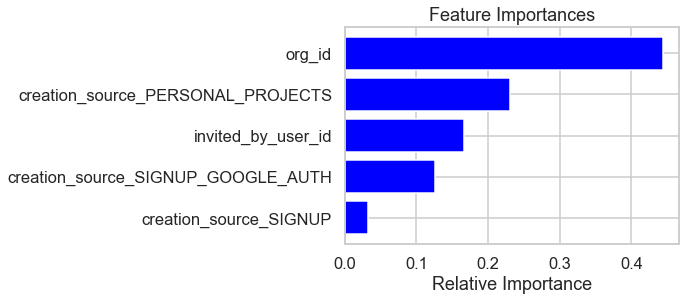

In [24]:
# check feature importance
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The top three determining features are the organization id, whether the creation source was personal projects, and what user id was invited by. These features are first features to consider if the company wants to improve their user adopted rate.